# Project Time domain data into lower dimensions
In this section, we will use UMAP (Uniform Manifold Approximation and Projection) to reduce the dimensionality of our time domain data from 1024 points down to just 2. This reduction allows us to visualize the structure of our high dimensional data in a 2D plot.

But why would we want to do this?

Even though each sample contains 1024 time domain values, it’s difficult to build an intuition about the data or spot patterns when we’re working in such high dimensional space. By projecting the data into two dimensions while preserving as much of its underlying structure as possible, we can:
	•	Explore the data visually: Clusters in the 2D plot might correspond to different physical properties of the samples (e.g., number of layers in a material, material type, etc.).
	•	Gain insights into separability: If we see well-defined clusters, that suggests the data contains meaningful differences that could be exploited by a machine learning model.
	•	Detect outliers: Points that lie far from any cluster may represent unusual or erroneous data.

UMAP is particularly well suited for this kind of task because it preserves both the local and global structure of the data better than older methods like PCA or t-SNE, especially when the data lies on a nonlinear manifold.


NOTE: The supporting data is not uploaded in this repository. Similar datasets can be generated with Data_gen_efficient.py

In [2]:
import torch
import umap
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

In [3]:
# Load the dataset with weights_only=False
data = torch.load("INSERT-PATH-TO-DATA", weights_only=False)

# Extract components
synthetic_data = data["synthetic_data"]
material_params = data["material_params"]
num_layers = data["num_layers"]

print("Dataset loaded successfully!")
print(f"Number of samples: {len(synthetic_data)}")
print(f"Shape of synthetic_data: {synthetic_data.shape}")
print(f"Shape of num_layers: {num_layers.shape}")
print(f"Example number of layers: {num_layers[:10]}")

num_classes = int(max(num_layers)) # class labels start at 1 not 0.

Dataset loaded successfully!
Number of samples: 60000
Shape of synthetic_data: torch.Size([60000, 1024])
Shape of num_layers: torch.Size([60000])
Example number of layers: tensor([3, 1, 2, 1, 1, 3, 1, 3, 1, 2])


In [4]:
# Convert to numpy for UMAP
X = synthetic_data.numpy()
y = num_layers.numpy()

# Run UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X)

/opt/anaconda3/envs/mphys/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/mphys/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


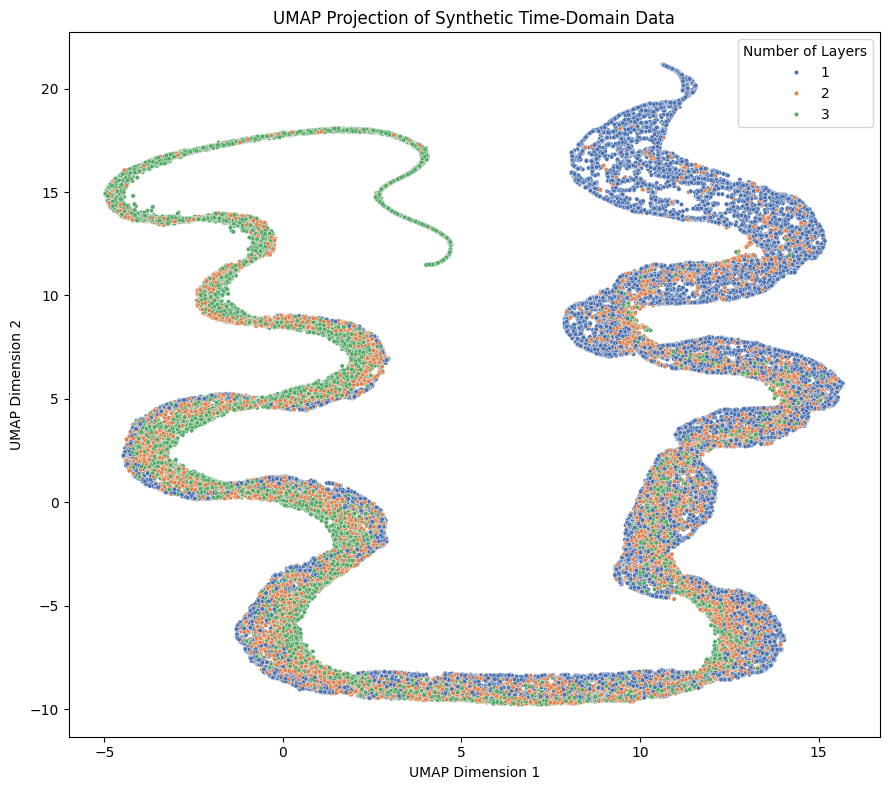

In [11]:
# Plot UMAP projection
plt.figure(figsize=(9, 8))
palette = sns.color_palette("deep", num_classes)

# Labels start at 1, adjust for color mapping
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y, palette=palette, legend='full', s=10)
plt.title("UMAP Projection of Synthetic Time-Domain Data")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="Number of Layers", loc="best")
plt.tight_layout()
plt.show()

/opt/anaconda3/envs/mphys/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/mphys/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/mphys/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


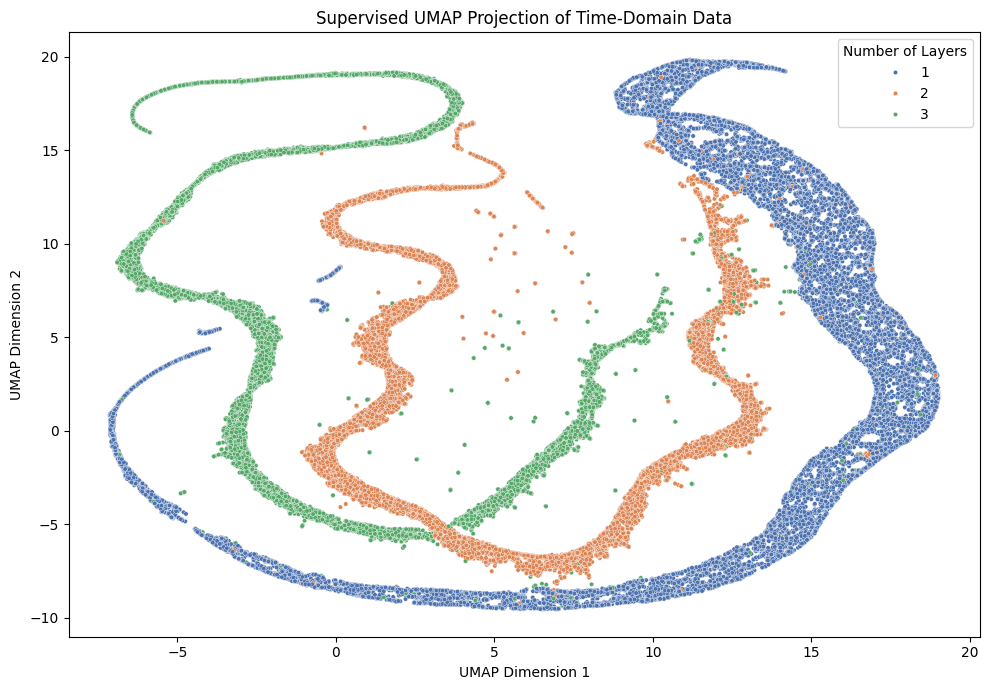

In [6]:
# Supervised UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap_supervised = reducer.fit_transform(X, y=y)  # Note: labels passed here

# Plotting
plt.figure(figsize=(10, 7))
palette = sns.color_palette("deep", int(max(y)))
sns.scatterplot(x=X_umap_supervised[:, 0], y=X_umap_supervised[:, 1],
                hue=y, palette=palette, legend='full', s=10)

plt.title("Supervised UMAP Projection of Time-Domain Data")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="Number of Layers", loc="best")
plt.tight_layout()
plt.show()

In [7]:
# Extract real(n) from first layer and total thickness
n_real = np.array([layer_params[0][0].real for layer_params in material_params])
total_thickness = np.array([
    sum([d for (_, d) in layer_params]) for layer_params in material_params
])

# Unsupervised UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X)

/opt/anaconda3/envs/mphys/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/mphys/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


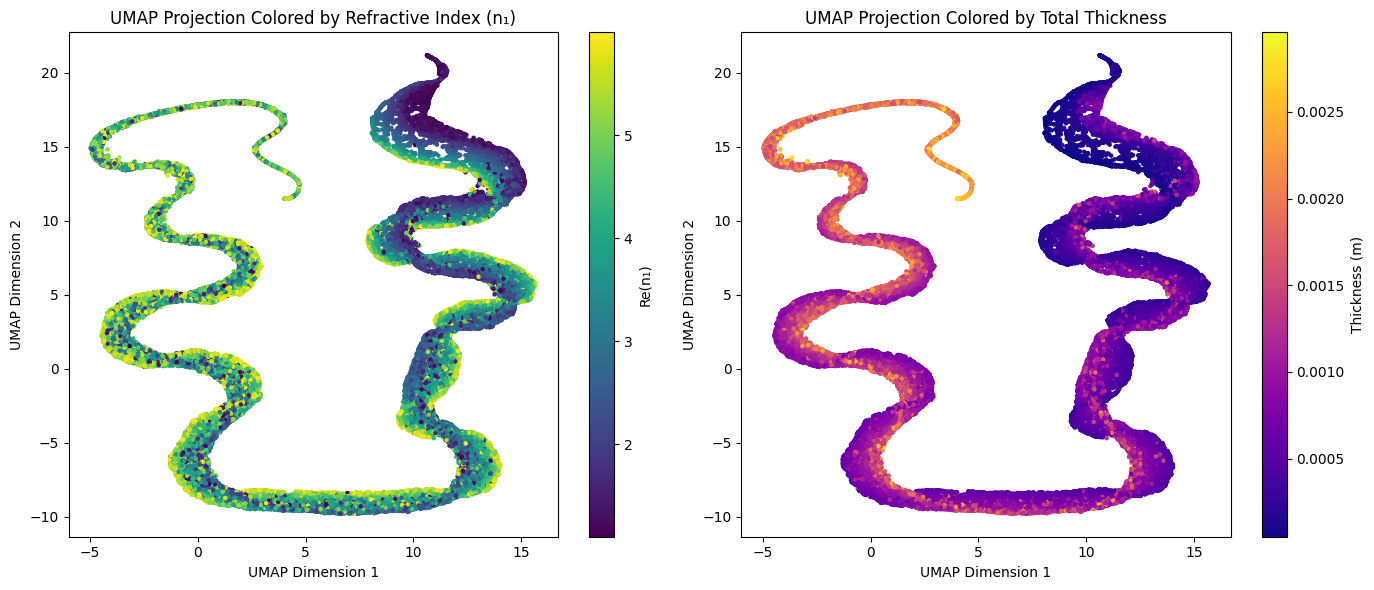

In [8]:
# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Left: n (real part of first layer)
sc1 = axs[0].scatter(X_umap[:, 0], X_umap[:, 1], c=n_real, cmap='viridis', s=5)
axs[0].set_title("UMAP Projection Colored by Refractive Index (n₁)")
axs[0].set_xlabel("UMAP Dimension 1")
axs[0].set_ylabel("UMAP Dimension 2")
plt.colorbar(sc1, ax=axs[0], label="Re(n₁)")

# Right: total thickness
sc2 = axs[1].scatter(X_umap[:, 0], X_umap[:, 1], c=total_thickness, cmap='plasma', s=5)
axs[1].set_title("UMAP Projection Colored by Total Thickness")
axs[1].set_xlabel("UMAP Dimension 1")
axs[1].set_ylabel("UMAP Dimension 2")
plt.colorbar(sc2, ax=axs[1], label="Thickness (m)")

plt.tight_layout()
plt.show()